# Code used in Luckie & Porritt (2023)
### Beamforming
Uses the algorithm of Rost & Thomas (2002). Slowness is calculated in cartesian space. A grid of possible slowness vectors is used to shift and stack waveforms according to the slowness contained in each grid cell to calculate the broadband array response function. 

### Waveform simulation framework (WSF)
This portion of the notebook is designed to illustrate the Waveform Simulation Framework.

This example has a few main steps:

First, we define a set of receivers on a spatial grid. We'll also setup an arbitrary boundary where we will use two different structural models.
Second, we define a source that we will simulate.
Third, we make a plot of sources and receivers in map view to confirm setup.
Fourth, we setup a execution job loop. This is to say, we build the set of functions that we will pass to a multiprocessing pool to run in parallel.
Fifth, we plot some waveforms to compare execution results.
Sixth, we add a minor step of post-processing to convert the waveforms into a python Pickle file.

### Noise modelling
Demonstrates how we create realistic randomly generated seismic earth noise from a background distribution. Here we use NLNM (Peterson, 1993). Adds frequency domain noise to a signal designed to match with an earth noise model amplitude is set by scale

### Back-projection
This is a simple script which performs 2-D backprojection through a homogenous earth model
using 1-D WSF forward model synthetics.

The backprojection is performed by stacking synthetic envelopes using traveltime shifts 
calculated over a grid search (Fee et al., 2021). Straight, Eucledean distances are calculated between each grid node
and receiver, with the travel time calculated using a constant velocity.

### Acknowledgements

This Source Physics Experiment (SPE) research was funded by the National Nuclear Security Administration, Defense Nuclear Nonproliferation Research and Development (NNSA DNN R&D). The authors acknowledge important interdisciplinary collaboration with scientists and engineers from LANL, LLNL, NNSS, and SNL.

This Ground-based Nuclear Detonation Detection (GNDD) research was funded by the National Nuclear Security Administration, Defense Nuclear Nonproliferation Research and Development (NNSA DNN R&D).  The authors acknowledge important interdisciplinary collaboration with scientists and engineers from Sandia National Laboratories. 

Sandia National Laboratories is a multi-mission laboratory managed and operated by National Technology and Engineering Solutions of Sandia, LLC, a wholly owned subsidiary of Honeywell International, Inc., for the U.S. Department of Energy’s National Security Administration under contract DE-NA-0003525.

Copyright 2023 National Technology & Engineering Solutions of Sandia, LLC (NTESS). Under the terms of Contract DE-NA0003525 with NTESS, the U.S. Government retains certain rights in this software.

SANDXXX-XXXXX



In [1]:
# Load modules

# Standards
import os
import math
import utm
import obspy

import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp

from scipy.signal import hilbert

from obspy import UTCDateTime, read, Stream
from obspy.taup import TauPyModel
model = TauPyModel(model="prem")

# Main classes from the framework
import generate_noise

import beamforming

from SourceAndReceivers import Source, Receiver
from PYFKSimulator import PYFKSimulation, PYFKModel, simulationCollection
from SimulatorModels import Model1D
from GE_Beamforming_Utils import convert_coords_to_utm, infill_das_sampling


# Supporting bits from the framework
from stfUtils import gaussian as gaussSTF
from stfUtils import cast_to_trace


In [2]:
# Input geometry
receiverCoords = np.load('geom/7gon.npy')


# Beamforming parameters

# Incoming source x,y slowness
Sx = 0.0
Sy = 0.0

# Slowness grid in s/m
slx_max = 0.0002
slx_min = -slx_max

sly_max = slx_max
sly_min = slx_min

slx_grid = 0.00001
sly_grid = slx_grid

# Bandlimited beamforming
freq_max = 5
freq_min = 0


# Forward model parameters
dt = 0.004
npt = 251

src_lat = np.median(receiverCoords[:,1])
src_lon = np.median(receiverCoords[:,0])
src_depth = 2

src_strike = 246
src_dip = 46
src_rake = -3


# Noise model parameters
noise_model = generate_noise.load_noise_model('peterson_NLNM.asc')

noise_factor = 0.1


# Back-projection parameters
Pvel = 5.8 # km/s; velocity used for BP calculation
xcells = 50 # Number of grid cells in x-direction
ycells = xcells

# I/O directories
simDir = "test_run"

# Define number of threads for PyFK pool
nthreads = 8


# Beamform

In [3]:
# Convert lat-lon to UTM
xll, yll, z = convert_coords_to_utm(receiverCoords, demean=False)

pts = []
yll_vec = []
for x, y in zip(xll, yll):
    pts.append([x[0], y[0]])
    yll_vec.append(yll)

# Array response technically is 0, 0, but these can be tweaked to see how the system responds
pts = np.asarray(pts)
slowvec = np.array([Sx, Sy])

# Here we just apply our slowness vector onto our set of points
a = np.dot(slowvec, pts.T)

# Here we setup the time domain parameters
min_t = -1 # begin time relative to nominal arrival
max_t = 1 # end time of stream
dt = 0.01 # time sampling
sigma1 = 0.01 # pulse width of the wavelet

nyq = 1/dt/2

# Creates the time array
timearray = np.arange(min_t, max_t, dt)
# Create a ricker wavelet on the time array as our nominal amplitude signal
amparray = beamforming.ricker_wavelet_td(timearray,sigma=sigma1) 

# Create a data array which has been shifted based on the arrival
dataarray = np.zeros((len(pts), len(amparray)))
for idx in range(len(pts)):
    tshift = a[idx]-0 # change the 0 here to set the nominal arrival time
    tmptime = timearray + tshift
    nptsshift = int(np.floor(tshift / dt+0.5))
    dataarray[idx,:] = np.roll(amparray, nptsshift)
    
# Apply DAS cos-squared amplitude function
# Two things we need:
#   Local azimuth of the das channel
#   Azimuth between das channel and source
for idx in range(0,len(pts)):
    
    if idx == 0:
        x0 = pts[idx,0]
        y0 = pts[idx,1]
        x1 = pts[-1,0]
        y1 = pts[-1,1]          
        
    else:
        x0 = pts[idx,0]
        y0 = pts[idx,1]
        x1 = pts[idx-1,0] # Assumes geometry is a closed loop/polygon
        y1 = pts[idx-1,1] # Adjust endpoint treament as needed
        
    local_angle = np.arctan2((y1-y0),(x1-x0))
    
    src_rec_angle = np.arctan2((Sy-y0),(Sx-x0))
    
    intersection_angle = local_angle-src_rec_angle
    
    amp_factor = np.cos(intersection_angle)**2
    
    dataarray[idx,:] *= amp_factor

    
# Just adjusting the time array to put origin at 0
timearray -= min_t

# Because the library is designed to work on obspy streams, here we convert the data into a stream
stream = obspy.Stream()
for idx in range(len(pts)):
    tr = obspy.Trace()
    tr.data = dataarray[idx,:]
    tr.stats.utmx = pts[idx,0] # Note that this code works on "utmx" and "utmy" as trace headers for location
    tr.stats.utmy = pts[idx,1] # These aren't part of the default trace header format, so I've added them.
    tr.stats.tshift_true = a[idx]
    tr.stats.delta = dt
    tr.stats.distance = np.sqrt(pts[idx,0]**2 + pts[idx,1]**2)
    tr.stats.sac = obspy.core.AttribDict()
    tr.stats.sac.b = 0
    stream += tr    

# originally, the beamforming code was designed to estimate the slowness at a specific location in the stream
# Therefore a number of the codes use a notion of a reference station
iref = 0


In [4]:
# Now we apply the 2D beamforming method
# Get the spectrums
print("Getting spectrums")
stream_spect, freqs = beamforming.parafft(stream, nthreads=nthreads)

print("Setting up grid")
# Setup the slowness grid
p = beamforming.setup_slowness_regular_grid(slx_min, slx_max, slx_grid,
                                            sly_min, sly_max, sly_grid)


# Find the centroid of the array
r0 = beamforming.get_stream_mean_location_utm(stream)

print("Stacking. This may take a while.")
# Actual stacking
stack = beamforming.run_frequency_domain_beamforming_starmap(stream_spect, p, freqs, r0, nthreads=nthreads)

print("Done stacking")
# Convert stack to more useful format
px, py, stack_clean = beamforming.disentangle_beamforming_stack(stack, freqs)


Getting spectrums
Setting up grid
Stacking. This may take a while.
Done stacking


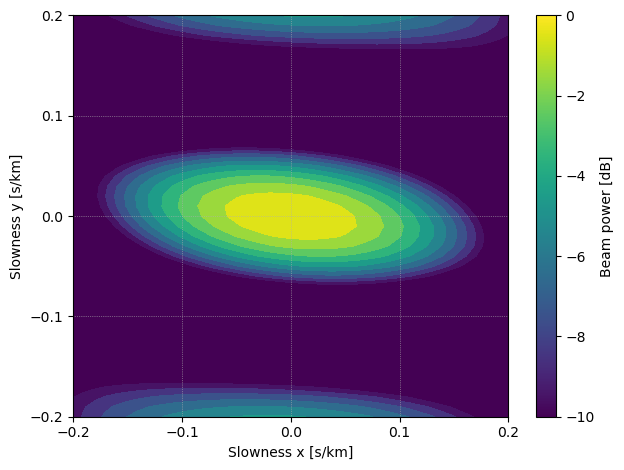

In [5]:
# Now we have the slownesses in x and y as px, py
# and the frequency dependent slowness as stack_clean
# So we can stack this overall frequencies with:
stack_all = beamforming.band_limited_beam_stack(stack_clean, freqs, fmin=freq_min, fmax=freq_max)

# Convert to dB
stack_all = abs(stack_all)
stack_all /= np.max(stack_all)
stack_all = 10*np.log10(stack_all**2)

# And plot:
plt.figure()

#            Convert s/m to s/km
plt.pcolormesh(px*1000, py*1000, stack_all.T,
               zorder=0,vmin=-10)
plt.colorbar(label='Beam power [dB]')

plt.contourf(px*1000, py*1000, stack_all.T,
             vmin=-10,levels=100)

plt.grid(lw=0.5,ls=':')
plt.xticks(np.linspace(-0.2,0.2,5))
plt.yticks(np.linspace(-0.2,0.2,5))
plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)
plt.xlabel("Slowness x [s/km]")
plt.ylabel("Slowness y [s/km]")

plt.tight_layout()
plt.show()


# WSF forward model

In [6]:
# Decimating receiver coordinatess to increase example computation speed
receiverCoords = receiverCoords[::50,:]

In [7]:

# Set up the receivers
receivers = []
models = []
boundary_latitude = min(min(receiverCoords[:,1]),src_lat)-1
for idx, rec in enumerate(receiverCoords):
    receivers.append(Receiver(rec, stationName="S{:03.0f}".format(idx)))
    # Simple flag switch for which model to prepare for each reciever
    if rec[1] <= boundary_latitude:
        models.append("ak135")
    else:
        models.append("prem")
        
        
        
# Setup the source
source = Source((src_lon, src_lat, src_depth), name="ExampleSource")
source.addDislocationComponent(strike=src_strike, dip=src_dip, rake=src_rake)
source.setSourceTimeFunction(type='Gaussian', alpha=-40)

sources = []
sources.append(source)


In [8]:
# Create execution loop
# As we do this for each receiver, we will also generate and associate the model. This particular paradigm will change slightly for 2D and 3D models.

if not os.path.exists(simDir):
    os.makedirs(simDir)
    

def setup_job(info: list) -> PYFKSimulation:
    # Initialize the simulation
    simulationIndex = info[0]
    UID = "{:08.0f}".format(simulationIndex)
    sim = PYFKSimulation(simDir=simDir, simID = UID)

    # Greab the prepared receiver for this simulation
    rec = info[1]
    sim.setReceiver(rec)

    # Gtab the prepared source for this simulation
    source = info[3]
    sim.setSource(source)

    # Prepare the model for this simulation
    model = Model1D()
    if info[2] == 'ak135':
        model.PyFK_TaupGenTestModel("ak135f_no_mud")
    else:
        model.PyFK_TaupGenTestModel("prem")
        
    # Cast into the form needed for this simulator
    pyfkmod = PYFKModel()
    pyfkmod.convert_Model1D(model)
    sim.setModel(pyfkmod)
    
    # Finally, set the simulation parameters and any necessary setup checks like CLF or dispersion conditions
    sim.setSimulationParameters(npt = npt, dt = dt)

    return sim

# Pack the simulation info into an iterable so we can call it in parallel
isim = 0
simCol = []
for irec, rec in enumerate(receivers):
    for isrc, src in enumerate(sources):
        info = [isim, rec, models[irec], src]
        sim = setup_job(info)
        simCol.append(sim)
        isim += 1

# simulationCollections descends from a list type. Importantly it has a packaged parallel execution method
simCol = simulationCollection(simCol)

# Here we actually run the simulations in parallel
simCol.execute_mp(nthreads=nthreads)

# The execution creates green's functions. Here we setup a source time function and use it to convert the results into displacement.
stf = gaussSTF(dt, 1)
# The source time function utility by default returns the source function as an ndarray of points. However, the 
# calculate_sync function used inside process data expects an obspy trace object.
stf = cast_to_trace(dt, stf[1])

# the processData method on a simulation object is something that should be checked and potentially adjusted
# if something different is regularly needed. At this point, the design is to convert the 9 component green's function
# tensor into displacement for a given source time function. The azimuth, used for the radiation pattern,
# is computed based on the source object and the source-receiver geometry.
for sim in simCol:
    if sim.Completed:
        sim.processData(stf=stf)
    else:
        print("Error, sim not completed")
        
        

Executing simulations on 8 threads.


In [9]:
# Cell to turn PyFK output into a more useful obspy stream
# This really could be cleaned up

st = Stream()
count = 0
for i in np.arange(0,len(simCol)):
    for j in np.arange(0,3):
        
        st += simCol[i].displacements[0][0][0][j].copy()
        
        st[count].stats.network = 'SYNTH'
        st[count].stats.station = "S{:03.0f}".format(i+1)
        st[count].stats.channel = ['Z','R','T'][j]
        
        st[count].stats.lat = simCol[i].receiver.lat
        st[count].stats.lon = simCol[i].receiver.lon
        st[count].stats.elev = simCol[i].receiver.elevation

        utmx, utmy, _, _ = utm.from_latlon(simCol[i].receiver.lat, simCol[i].receiver.lon)
        st[count].stats.utmx = utmx
        st[count].stats.utmy = utmy
        
        st[count].stats.distance = st[count].stats.sac.dist*1000
        
        count += 1

# Align traces with origin time
# Needed due to PyFK's timing scheme
st.trim(starttime=UTCDateTime("1970-01-01T00:00:00")-1,
        endtime=UTCDateTime("1970-01-01T00:00:00")+((npt)*dt),
        pad=True,fill_value = 0)

st.interpolate(sampling_rate=dt**-1,
               npts=npt,
               starttime=UTCDateTime("1970-01-01T00:00:00"),
               method='lanczos',a=20)

for itr, tr in enumerate(st):
    st[itr].stats.distance = tr.stats.sac.dist*1000
    
st_Z = st.select(channel='Z')
st_R = st.select(channel='R')
st_T = st.select(channel='T')


In [10]:
st_DAS = st.copy()

amp_factor_vec = []

Sx,Sy,_,_ = utm.from_latlon(src_lat,src_lon)

for idx in range(0,len(st_DAS)):
    
    if idx == 0:
        x0 = st_DAS[idx].stats.utmx
        y0 = st_DAS[idx].stats.utmy
        x1 = st_DAS[-1].stats.utmx
        y1 = st_DAS[-1].stats.utmx         
        
    else:
        x0 = st_DAS[idx].stats.utmx
        y0 = st_DAS[idx].stats.utmy
        x1 = st_DAS[idx-1].stats.utmx # Assumes geometry is a closed loop/polygon
        y1 = st_DAS[idx-1].stats.utmy # Adjust endpoint treament as needed
        
    local_angle = np.arctan2((y1-y0),(x1-x0))
    
    src_rec_angle = np.arctan2((Sy-y0),(Sx-x0))
    
    intersection_angle = local_angle-src_rec_angle
    
    st_DAS[idx].stats.back_azimuth = (np.rad2deg(intersection_angle)+90)%360
    
    amp_factor = np.cos(intersection_angle)**2
    amp_factor_vec.append(amp_factor)
    
st_DAS.rotate(method='RT->NE')
    
for idx in range(0,len(st_DAS)):
    
    st_DAS[idx].data *= amp_factor_vec[idx]
    st_DAS[idx].stats.network = 'DAS'
    
st_DAS = st_DAS.select(channel='Z')



# Save obspy streams:

st_Z.write('syn_data/syn_Z.sac',format='sac')
st_R.write('syn_data/syn_R.sac',format='sac')
st_T.write('syn_data/syn_T.sac',format='sac')

st_DAS.write('syn_data/syn_DAS.sac',format='sac')



In [11]:
# Read DAS stream generated by above cells:

st_DAS = read('syn_data/syn_DAS*.sac')


# Noise model

Uncomment to add noise

In [12]:
st_DAS_noise = st_DAS.copy()

for i in np.arange(0,len(st_DAS_noise)):

    st_DAS_noise[i].data = generate_noise.add_earth_noise(st_DAS_noise[i],
                                                          st_DAS_noise[i].stats.delta, 
                                                          noise_factor,
                                                          noise_model)
    

# Back-projection

In [13]:
# Prepare stream for grid search stacking procedure
# by calculating envelope

st_BP = st_DAS.copy()

# Remove secondary arrivals
for i in np.arange(0,len(st_BP)):
    arrivals = model.get_travel_times(source_depth_in_km=src_depth,
                          distance_in_degree=st_BP[i].stats.sac.dist/111,
                          phase_list=["p"])
    ii = np.where(st_BP[0].times() >= arrivals[0].time+0.1)[0]
    st_BP[i].data[ii] = 0

    st_BP[i].data = abs(hilbert(st_BP[i].data))

st_BP.normalize(global_max=True)

# Read in geomoetry file
coords = np.loadtxt('coords.csv',delimiter=",")
x, y, z = convert_coords_to_utm(coords, demean=False)
xsynth, ysynth = infill_das_sampling(x, y, channel_separation=100)

In [14]:
# Set up back-projection grid to be centered at 0,0
xsynth_BP = xsynth - min(xsynth)
ysynth_BP = ysynth - min(ysynth)

# Extend grid to +/- 1 km from edges of array with 50x50 cells
xgrid = np.linspace(float(min(xsynth_BP))-1000,
                    float(max(xsynth_BP))+1000,xcells)
ygrid = np.linspace(float(min(ysynth_BP))-1000,
                    float(max(ysynth_BP))+1000,ycells)

# Declare stack array
A = np.zeros((len(xgrid),len(ygrid),npt))

# Perform stacking for each x,y grid node
for i in np.arange(0,len(xgrid)):
    for j in np.arange(0,len(ygrid)):
        st_temp = st_BP.copy()
        for n in np.arange(0,len(st_BP)):
            
            # For each station, calculate the euclidean distance...
            euc_dist = np.sqrt((xsynth_BP[n]-xgrid[i])**2+(ysynth_BP[n]-ygrid[j])**2+(src_depth*1000)**2)/1000
            
            # ...find the expected time shift using a constant velocity...
            tshift = euc_dist/Pvel
            
            # ...shift the trace accordingly...
            st_temp[n].interpolate(sampling_rate=int(1/dt),
                                   # This is where tshift is applied
                                   time_shift=-1*float(tshift))
        
        # ...pad the stream in preparation to...
        st_temp.trim(starttime=st[0].stats.starttime-1,
                endtime=st[0].stats.endtime+1,
                pad=True,fill_value = 0)
        
        # ...stack the stream
        st_stack = st_temp.copy().stack()
        st_stack.trim(starttime=st[0].stats.starttime+1,
                endtime=st[0].stats.endtime+1,
                pad=True,fill_value = 0)
        
        # Add to stack array
        A[i,j,:] = st_stack[0].data

# Normalize and find maximum in x,y,t space
A /= np.max(abs(A))
idx_max = np.unravel_index(A.argmax(), A.shape)

err = float(np.sqrt((np.asarray(xgrid)[idx_max[0]]-(utm.from_latlon(src_lat,src_lon)[0]- min(xsynth)))**2+\
                    (np.asarray(ygrid)[idx_max[1]]-(utm.from_latlon(src_lat,src_lon)[1]- min(ysynth)))**2))


# Print some useful information
print('grid spacing: ~'+str(round(xgrid[1]-xgrid[0]))+' m')
print('dist error: '+str(int(err))+' m')
print('time error: '+str(idx_max[2]*dt)+' sec')


grid spacing: ~60 m
dist error: 128 m
time error: 0.03 sec


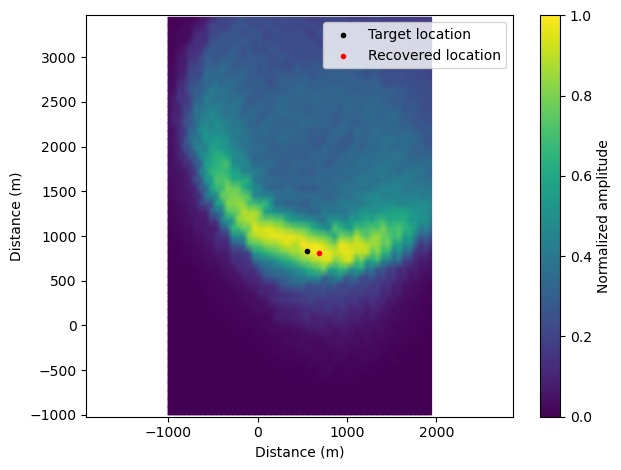

In [15]:
# Plot back-projection results

plt.pcolormesh(np.asarray(xgrid),
               np.asarray(ygrid),
               A[:,:,idx_max[2]].T,shading='gouraud',vmax=1,vmin=0)
plt.colorbar(label='Normalized amplitude')

plt.scatter(utm.from_latlon(src_lat,src_lon)[0]- min(xsynth),
            utm.from_latlon(src_lat,src_lon)[1]- min(ysynth),
            c='k',marker='.',label='Target location',zorder=5)
plt.scatter(np.asarray(xgrid)[idx_max[0]],
            np.asarray(ygrid)[idx_max[1]],
            c='r',marker='.',zorder=9,label='Recovered location')

plt.legend()

plt.xlim(0,max(xsynth_BP))
plt.ylim(0,max(ysynth_BP))

plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

plt.gca().axis('equal')

plt.grid(visible=False)

plt.tight_layout()